In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, GRU, Dense, Dropout, BatchNormalization,
    Flatten, TimeDistributed, Bidirectional, LayerNormalization, MultiHeadAttention
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [ ]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets
normal_file_path = '/content/drive/MyDrive/project-3/data/ptbdb_normal.csv'  # Update with the actual path
abnormal_file_path = '/content/drive/MyDrive/project-3/data/ptbdb_abnormal.csv'  # Update with the actual path

In [ ]:
# Load normal and abnormal data
def load_and_label_data(file_path, label):
    data = pd.read_csv(file_path).values
    data[:, -1] = label  # Assign the label to the last column
    return data

normal_data = load_and_label_data(normal_file_path, label=0)
abnormal_data = load_and_label_data(abnormal_file_path, label=1)

# Combine datasets
data = np.vstack((normal_data, abnormal_data))

In [ ]:
# Advanced preprocessing
# Apply Savitzky-Golay filtering to smooth signals
def preprocess_data(data, label_col=-1):
    signals = data[:, :label_col]  # Extract signals
    labels = data[:, label_col]   # Extract labels
    # Apply smoothing
    smoothed_signals = np.array([savgol_filter(signal, window_length=5, polyorder=2) if len(signal) >= 5 else signal for signal in signals])
    return smoothed_signals, labels

In [ ]:
# Preprocess data
X_raw, y = preprocess_data(data)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_raw.reshape(-1, X_raw.shape[-1])).reshape(X_raw.shape)

In [ ]:
# Data augmentation
# Add random noise to signals
noise_factor = 0.01
X_augmented = X_standardized + noise_factor * np.random.normal(size=X_standardized.shape)
X_combined = np.vstack([X_standardized, X_augmented])
y_combined = np.hstack([y, y])

In [ ]:
# Reshape data for GRU input (add time dimension)
X_combined = np.expand_dims(X_combined, axis=-1)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(GRU(64, return_sequences=True))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = GRU(32)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create and train the model
model = create_model(input_shape=X_train.shape[1:])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 187, 128)            │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 187, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 187, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 32)                  │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,825 (163.38 KB)

 Trainable params: 41,569 (162.38 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Callbacks for better training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7167 - loss: 0.5981 - val_accuracy: 0.7143 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 2/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7179 - loss: 0.5980 - val_accuracy: 0.7111 - val_loss: 0.5994 - learning_rate: 0.0010
Epoch 3/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7170 - loss: 0.5639 - val_accuracy: 0.7404 - val_loss: 0.4879 - learning_rate: 0.0010
Epoch 4/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.7574 - loss: 0.4769 - val_accuracy: 0.8073 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 5/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8036 - loss: 0.4124 - val_accuracy: 0.8364 - val_loss: 0.3695 - learning_rate: 0.0010
Epoch 6/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8318 - loss: 0.3663 - val_accuracy: 0.8431 - val_loss: 0.3403 - learning_rate: 0.0010
Epoch 7/50
637/637 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8667 - l

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9929 - loss: 0.0237
Test Accuracy: 0.99


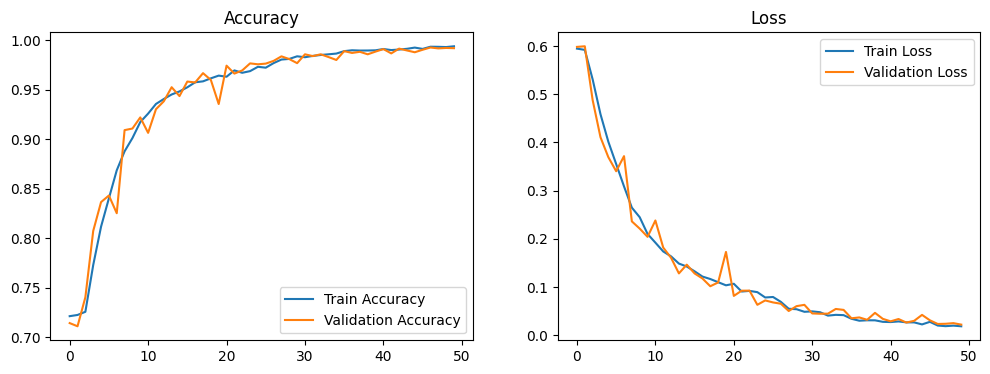

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1189
         1.0       0.99      1.00      1.00      3176

    accuracy                           0.99      4365
   macro avg       0.99      0.99      0.99      4365
weighted avg       0.99      0.99      0.99      4365



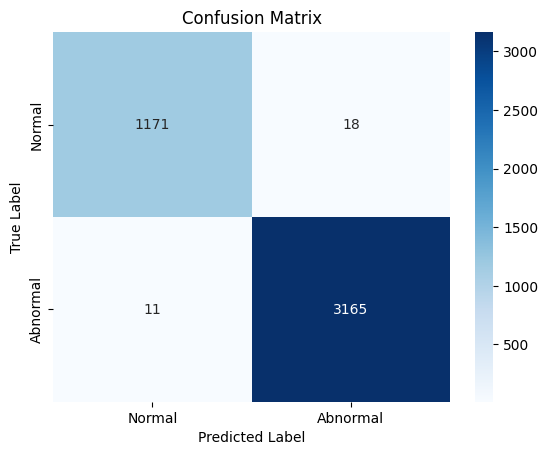

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/ecg_model.h5')